In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
inicio_ejecucion = time.time()

# Importamos las características extraídas

In [24]:
url_features_fullfin='https://raw.githubusercontent.com/BenjaminIrarrazabal/Datos-Supernovas-Pruebas/main/features_fullfin.csv'
features_full = pd.read_csv(url_features_fullfin, index_col=None)
features_full

,oid,delta_mag_fid_1,positive_fraction_1,delta_mag_fid_2,positive_fraction_2,Multiband_period,PPE,Period_band_1,delta_period_1,Period_band_2,delta_period_2,MHPS_ratio_1,MHPS_low_1,MHPS_high_1,MHPS_ratio_2,MHPS_low_2,MHPS_high_2,GP_DRW_sigma_1,GP_DRW_tau_1,GP_DRW_sigma_2,GP_DRW_tau_2,Psi_CS_1,Psi_eta_1,Psi_CS_2,Psi_eta_2,Harmonics_mag_1_1,Harmonics_mag_2_1,Harmonics_mag_3_1,Harmonics_mag_4_1,Harmonics_mag_5_1,Harmonics_mag_6_1,Harmonics_mag_7_1,Harmonics_phase_2_1,Harmonics_phase_3_1,Harmonics_phase_4_1,Harmonics_phase_5_1,Harmonics_phase_6_1,Harmonics_phase_7_1,Harmonics_mse_1,Harmonics_mag_1_2,...,IAR_phi_1,LinearTrend_1,Amplitude_2,AndersonDarling_2,Autocor_length_2,Beyond1Std_2,Con_2,Gskew_2,Meanvariance_2,MedianAbsDev_2,MedianBRP_2,PairSlopeTrend_2,PercentAmplitude_2,Q31_2,Rcs_2,Skew_2,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,SPM_A_1,SPM_t0_1,SPM_gamma_1,SPM_beta_1,SPM_tau_rise_1,SPM_tau_fall_1,SPM_chi_1,SPM_A_2,SPM_t0_2,SPM_gamma_2,SPM_beta_2,SPM_tau_rise_2,SPM_tau_fall_2,SPM_chi_2,classALeRCE
0,ZTF17aadlxmv,2.244800,1.0,1.847730,1.0,51.630429,0.018797,0.200240,51.430189,0.069774,51.560655,24.510580,3.971278,0.162023,26.178661,1.065202,0.040690,0.623412,11.018541,2.974256e-01,12.709005,0.441628,0.342535,0.361719,0.345065,5.176898e+01,2.247800e+01,16.378288,8.031787,35.167310,45.593497,65.823023,2.799746,3.812070,4.416340,3.855748,0.801975,3.920080,4.069061e-24,0.740893,...,0.903700,0.019445,0.923865,0.999412,3.0,0.222222,0.0,0.511683,0.025176,0.346074,0.388889,-0.500000,0.063359,0.657760,0.361719,0.767211,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989,0.339168,5.039542,21.779838,0.642127,2.329821,11.688850,0.007554,0.311686,6.958042,21.231870,0.416775,3.677212,30.091575,0.594409,SNIa
1,ZTF18aaaqexr,0.896138,1.0,0.191736,1.0,29.230770,0.000933,29.230770,0.000000,NaN,NaN,0.216739,0.046887,0.216330,NaN,NaN,NaN,0.062597,5.697961,5.886294e-07,0.983179,0.429391,1.045772,NaN,NaN,5.805312e+00,2.222749e+00,2.623629,1.479667,2.946373,2.618439,1.582411,2.209948,3.903036,1.966469,0.564790,3.835875,0.632893,1.865218e-28,2.142465,...,0.841811,0.026267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.198096,0.504445,2.074475,0.112886,1.205329,17.585409,0.281999,0.292699,-8.394195,9.801748,0.447687,8.599671,32.414657,NaN,SNIa
2,ZTF18aacdbzx,0.495977,1.0,0.786995,1.0,0.156563,0.004384,0.165508,0.008945,0.185710,0.029147,0.752135,0.016245,0.021599,8.221117,0.073785,0.008975,0.012080,1.541608,7.029221e-02,15.265901,0.366780,1.010175,0.364474,0.463809,3.731002e+00,1.030580e+00,4.626807,2.398018,2.417238,1.966842,6.632274,5.789298,4.023447,2.294776,3.697512,4.121476,5.312111,1.992437e-28,621.990994,...,0.799329,0.011157,0.393497,0.999341,2.0,0.100000,0.0,0.379781,0.011028,0.105004,0.200000,-0.366667,0.030335,0.257782,0.381896,1.301440,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806,0.183777,-7.254930,1.000737,0.333585,3.344743,24.821414,0.033287,0.114159,-5.114678,13.845587,0.063725,10.514456,20.820922,0.044529,SNIbc
3,ZTF18aadmssd,3.293953,1.0,2.170098,1.0,1.005344,0.056145,0.065053,0.940291,999.999953,998.994608,337.794556,34.621597,0.102493,342.520355,12.741676,0.037200,2.073645,117.090145,9.575899e-01,191.232153,0.434424,0.953035,0.270602,0.644786,7.272322e+00,2.503748e+00,2.237135,0.544766,3.829564,2.494791,5.496666,0.629241,1.759490,5.585220,4.970962,4.485922,2.156395,5.062500e-12,524.937163,...,0.986739,0.053669,1.085049,0.990112,6.0,0.200000,0.0,-0.184004,0.037748,0.418592,0.466667,-0.100000,0.066553,0.901432,0.403816,-0.066124,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800,1.462569,-20.995965,28.830318,0.763144,2.939169,22.204705,0.010855,2.067952,-22.606536,39.255644,0.755130,17.087420,46.760686,1.111489,SNIIn
4,ZTF18aadzfso,1.371363,1.0,0.797367,1.0,1.028361,0.034737,1.029866,0.001505,37.037036,36.008675,0.751511,0.199288

### Contamos la cantidad de ejemplos que tenemos de cada clase

In [3]:
count_clase1 = pd.DataFrame({'classALeRCE':features_full['classALeRCE']})
count_clase1.groupby(count_clase1.columns.tolist(),as_index=False).size()

,classALeRCE,size
0,SLSN,34
1,SNII,330
2,SNIIb,16
3,SNIIn,42
4,SNIa,1540
5,SNIbc,106


### Escogemos solamente las características correspondientes al SMP extractor, eliminando las que presentaban muchos NaN (que no eran importantes)

In [31]:
Features_most_important=features_full.iloc[:,[105,106,107,108,109,110,112,113,114,115,116,117,119]]

### Se agrupan las clases SNIIb y SNIIn en SNII para tratar el desbalance

In [32]:
# Unimos las clases II
Features_most_important['classALeRCE']= Features_most_important['classALeRCE'].replace(['SNIIb','SNIIn'],'SNII')
Features_most_important

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SPM_A_1,SPM_t0_1,SPM_gamma_1,SPM_beta_1,SPM_tau_rise_1,SPM_tau_fall_1,SPM_A_2,SPM_t0_2,SPM_gamma_2,SPM_beta_2,SPM_tau_rise_2,SPM_tau_fall_2,classALeRCE
0,0.339168,5.039542,21.779838,0.642127,2.329821,11.688850,0.311686,6.958042,21.231870,0.416775,3.677212,30.091575,SNIa
1,0.198096,0.504445,2.074475,0.112886,1.205329,17.585409,0.292699,-8.394195,9.801748,0.447687,8.599671,32.414657,SNIa
2,0.183777,-7.254930,1.000737,0.333585,3.344743,24.821414,0.114159,-5.114678,13.845587,0.063725,10.514456,20.820922,SNIbc
3,1.462569,-20.995965,28.830318,0.763144,2.939169,22.204705,2.067952,-22.606536,39.255644,0.755130,17.087420,46.760686,SNII
4,0.211340,5.369244,5.263729,0.073824,3.554785,14.225590,0.257985,4.309859,18.030779,0.606823,3.959666,85.046548,SNIa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,0.242148,1.301380,28.888657,0.813951,3.176700,24.208459,0.287074,4.316311,14.243011,0.570416,4.845104,28.891699,SNIa
2064,0.254616,4.286499,7.378845,0.633756,6.300684,10.058191,0.245715,12.104669,2.379968,0.340972,6.101363,14.828741,SNIa
2065,0.448833,5.252311,18.219174,0.269451,3.415255,19.974876,0.401462,5.696663,35.855804,0.521981,3.882842,30.064703,SNIa
2066,0.139119,-2.485711,20.374523,0.003264,21.405156,4.324015,0.145629,4.926039,8.235528,0.014039,2.534046,19.833969,SNIa


### Se observa cuantos NaN existen en cada columna

In [33]:
Features_most_important.isnull().sum()

SPM_A_1           30
SPM_t0_1          30
SPM_gamma_1       30
SPM_beta_1        30
SPM_tau_rise_1    30
SPM_tau_fall_1    30
SPM_A_2           13
SPM_t0_2          13
SPM_gamma_2       13
SPM_beta_2        13
SPM_tau_rise_2    13
SPM_tau_fall_2    13
classALeRCE        0
dtype: int64

### Se eliminan las filas con al menos 1 dato de tipo NaN
(quedando con 2025 muestras)

In [35]:
features=Features_most_important.dropna(thresh=13)
features

,SPM_A_1,SPM_t0_1,SPM_gamma_1,SPM_beta_1,SPM_tau_rise_1,SPM_tau_fall_1,SPM_A_2,SPM_t0_2,SPM_gamma_2,SPM_beta_2,SPM_tau_rise_2,SPM_tau_fall_2,classALeRCE
0,0.339168,5.039542,21.779838,0.642127,2.329821,11.688850,0.311686,6.958042,21.231870,0.416775,3.677212,30.091575,SNIa
1,0.198096,0.504445,2.074475,0.112886,1.205329,17.585409,0.292699,-8.394195,9.801748,0.447687,8.599671,32.414657,SNIa
2,0.183777,-7.254930,1.000737,0.333585,3.344743,24.821414,0.114159,-5.114678,13.845587,0.063725,10.514456,20.820922,SNIbc
3,1.462569,-20.995965,28.830318,0.763144,2.939169,22.204705,2.067952,-22.606536,39.255644,0.755130,17.087420,46.760686,SNII
4,0.211340,5.369244,5.263729,0.073824,3.554785,14.225590,0.257985,4.309859,18.030779,0.606823,3.959666,85.046548,SNIa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,0.242148,1.301380,28.888657,0.813951,3.176700,24.208459,0.287074,4.316311,14.243011,0.570416,4.845104,28.891699,SNIa
2064,0.254616,4.286499,7.378845,0.633756,6.300684,10.058191,0.245715,12.104669,2.379968,0.340972,6.101363,14.828741,SNIa
2065,0.448833,5.252311,18.219174,0.269451,3.415255,19.974876,0.401462,5.696663,35.855804,0.521981,3.882842,30.064703,SNIa
2066,0.139119,-2.485711,20.374523,0.003264,21.405156,4.324015,0.145629,4.926039,8.235528,0.014039,2.534046,19.833969,SNIa


### Se calcula nuevamente la cantidad de ejemplos por clase presente, observando que aún existe un gran desbalance

In [38]:
count_clase1 = pd.DataFrame({'classALeRCE':features['classALeRCE']})
count_clase1.groupby(count_clase1.columns.tolist(),as_index=False).size()

,classALeRCE,size
0,SLSN,34
1,SNII,376
2,SNIa,1512
3,SNIbc,103


# Comienzan las Clasificaciones

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # se codifica la clase
le = LabelEncoder()


X, y = features.iloc[:,:-1], features['classALeRCE']
# label encode the target variable
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
classifier_0 = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=30,
    max_features='sqrt',
    n_jobs=-1,
    class_weight='balanced'
)
classifier_0.fit(X_train,y_train)

#------------------SE PRUEBA EL CLASIFICADOR----------------------------------
# predict new data:
#pues solo usaremos el target para comprobar la eficacia de la predicción

pred_labels_0 = classifier_0.predict(X_test)

### Clasificación con datos desbalanceados

In [44]:
# calculate accuracy
from sklearn import metrics
accuracy_0= metrics.accuracy_score(y_test, pred_labels_0)*100
presicion_0 = metrics.precision_score(y_test, pred_labels_0,average='macro')*100
recall_0 = metrics.recall_score(y_test, pred_labels_0,average='macro')*100
print("Classification accuracy is %2f"%accuracy_0,"%")
print("Classification precision is %2f"%presicion_0,"%")
print("Classification recall is %2f"%recall_0,"%")

Classification accuracy is 83.826430 %
Classification precision is 40.701357 %
Classification recall is 39.484848 %


In [45]:
y_sin_codificar = le.inverse_transform(y)
np.unique(y),np.unique(y_sin_codificar)
df = pd.DataFrame()
df['ClassALeRCE']=np.unique(y_sin_codificar)
df['Codificación']=np.unique(y)
df

,ClassALeRCE,Codificación
0,SLSN,0
1,SNII,1
2,SNIa,2
3,SNIbc,3


In [46]:
count_clase3 = pd.DataFrame({'y_train':y_train})
count_clase3 = count_clase3.groupby(count_clase3.columns.tolist(),as_index=False).size()
count_clase3 

,y_train,size
0,0,26
1,1,277
2,2,1137
3,3,78


In [47]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder # se codifica la clase

le = LabelEncoder()

# transform the dataset
# clase 0 : SLSN, clase 1: SNII, clase 2: SNIa,clase 3 = SNIbc
oversample = SMOTE(sampling_strategy = {0: count_clase3['size'][0]*10, 1: count_clase3['size'][1]*2, 2: count_clase3['size'][2]*1, 3: count_clase3['size'][3]*5})
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [48]:
count_clase5 = pd.DataFrame({'classALeRCE': y_train_smote})
count_clase5.groupby(count_clase5.columns.tolist(),as_index=False).size()

,classALeRCE,size
0,0,260
1,1,554
2,2,1137
3,3,390


In [49]:
classifier = RandomForestClassifier()
#-----------------------ENTRENAMIENTO-----------------------------------------
classifier.fit(X_train_smote,y_train_smote)

#------------------SE PRUEBA EL CLASIFICADOR----------------------------------
# predict new data:
#pues solo usaremos el target para comprobar la eficacia de la predicción

pred_labels = classifier.predict(X_test)

### Clasificación con datos balanceados

In [50]:
# calculate accuracy
from sklearn import metrics
accuracy= metrics.accuracy_score(y_test, pred_labels)*100
presicion= metrics.precision_score(y_test, pred_labels,average='macro')*100
recall = metrics.recall_score(y_test, pred_labels,average='macro')*100
print("Classification accuracy is %2f"%accuracy,"%")
print("Classification precision is %2f"%presicion,"%")
print("Classification recall is %2f"%recall,"%")

Classification accuracy is 86.193294 %
Classification precision is 64.950330 %
Classification recall is 61.358333 %


Text(609.9818181818181, 0.5, 'True Label')

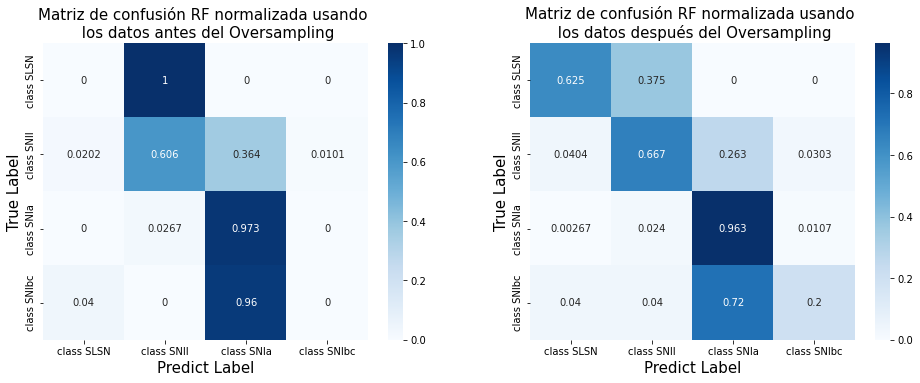

In [52]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt


columns = ['class %s' %(i) for i in np.unique(y_sin_codificar)]


fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(2, 2, 1)

confm_1 = confusion_matrix(y_test, pred_labels_0,normalize='true')
df_cm_1 = pd.DataFrame(confm_1, index=columns, columns=columns)
ax_1 = sn.heatmap(df_cm_1, cmap='Blues',fmt='.3g', ax=ax, annot=True)
#sn.set(rc={'figure.figsize':(16,12)})
ax_1.set_title('Matriz de confusión RF normalizada usando \n los datos antes del Oversampling',fontsize=15)
ax_1.set_xlabel('Predict Label',fontsize=15)
ax_1.set_ylabel('True Label',fontsize=15)

ax = fig.add_subplot(2, 2, 2)
confm_2 = confusion_matrix(y_test, pred_labels,normalize='true')
df_cm_2 = pd.DataFrame(confm_2, index=columns, columns=columns)
ax_2 = sn.heatmap(df_cm_2, cmap='Blues',fmt='.3g',ax=ax, annot=True)
#sn.set(rc={'figure.figsize':(16,12)})
ax_2.set_title('Matriz de confusión RF normalizada usando \n los datos después del Oversampling',fontsize=15)
ax_2.set_xlabel('Predict Label',fontsize=15)
ax_2.set_ylabel('True Label',fontsize=15)

### Se prueban los clasificadores obtenidos por Gridsearch y Randomizedsearch (se deben corregir aún)

In [59]:
#    class_weight='balanced'
best_classifier_1 = RandomForestClassifier(
    n_estimators=300,
    max_depth=100,
    max_features= 12,
    min_samples_leaf=3,
    min_samples_split= 8,
    bootstrap=True
)
best_classifier_1.fit(X_train_smote,y_train_smote)
#------------------SE PRUEBA EL CLASIFICADOR----------------------------------
# predict new data:
#pues solo usaremos el target para comprobar la eficacia de la predicción

pred_labels_1 = best_classifier_1.predict(X_test)

In [60]:
# calculate accuracy
from sklearn import metrics
accuracy_1 = metrics.accuracy_score(y_test, pred_labels_1)*100
presicion_1 = metrics.precision_score(y_test, pred_labels_1,average='macro')*100
recall_1 = metrics.recall_score(y_test, pred_labels_1,average='macro')*100
print("Classification accuracy is %2f"%accuracy_1,"%")
print("Classification precision is %2f"%presicion_1,"%")
print("Classification recall is %2f"%recall_1,"%")

Classification accuracy is 83.826430 %
Classification precision is 57.196545 %
Classification recall is 60.186616 %


Text(609.9818181818181, 0.5, 'True Label')

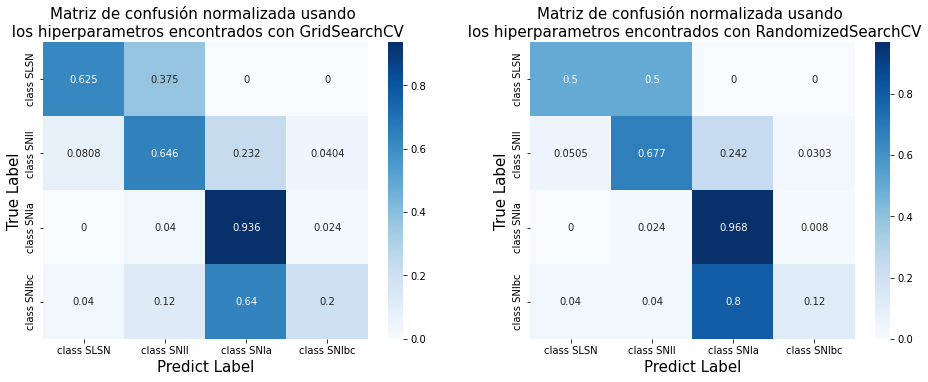

In [61]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

columns = ['class %s' %(i) for i in np.unique(y_sin_codificar)]


fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(2, 2, 1)

confm_1 = confusion_matrix(y_test, pred_labels_1,normalize='true')
df_cm_1 = pd.DataFrame(confm_1, index=columns, columns=columns)
ax_1 = sn.heatmap(df_cm_1, cmap='Blues',fmt='.3g', ax=ax, annot=True)
#sn.set(rc={'figure.figsize':(16,12)})
ax_1.set_title('Matriz de confusión normalizada usando \n los hiperparametros encontrados con GridSearchCV',fontsize=15)
ax_1.set_xlabel('Predict Label',fontsize=15)
ax_1.set_ylabel('True Label',fontsize=15)

ax = fig.add_subplot(2, 2, 2)
confm_2 = confusion_matrix(y_test, pred_labels_2,normalize='true')
df_cm_2 = pd.DataFrame(confm_2, index=columns, columns=columns)
ax_2 = sn.heatmap(df_cm_2, cmap='Blues',fmt='.3g',ax=ax, annot=True)
#sn.set(rc={'figure.figsize':(16,12)})
ax_2.set_title('Matriz de confusión normalizada usando \n los hiperparametros encontrados con RandomizedSearchCV',fontsize=15)
ax_2.set_xlabel('Predict Label',fontsize=15)
ax_2.set_ylabel('True Label',fontsize=15)

In [62]:
#    class_weight='balanced'
best_classifier_2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=100,
    max_features= 'auto',
    min_samples_leaf=1,
    min_samples_split= 2,
    bootstrap=False
)
best_classifier_2.fit(X_train_smote,y_train_smote)

#------------------SE PRUEBA EL CLASIFICADOR----------------------------------
# predict new data:
#pues solo usaremos el target para comprobar la eficacia de la predicción

pred_labels_2 = best_classifier_2.predict(X_test)

In [63]:
# calculate accuracy
from sklearn import metrics
accuracy_2 = metrics.accuracy_score(y_test, pred_labels_2)*100
presicion_2 = metrics.precision_score(y_test, pred_labels_2,average='macro')*100
recall_2 = metrics.recall_score(y_test, pred_labels_2,average='macro')*100
print("Classification accuracy is %2f"%accuracy_2,"%")
print("Classification precision is %2f"%presicion_2,"%")
print("Classification recall is %2f"%recall_2,"%")

Classification accuracy is 85.404339 %
Classification precision is 61.319973 %
Classification recall is 56.728283 %


In [64]:
if accuracy_2>accuracy_1:
    print("El mejor modelo es el que utiliza los hiperparametros encontrandos usando RandomizedSearchCV")
    print("""{'n_estimators': 100,\n 'min_samples_split': 2,\n 'min_samples_leaf': 1,\n 'max_features': 'auto',\n 'max_depth': 100,\n 'bootstrap': False}""")
    best_classifier = best_classifier_2
    pred_labels=pred_labels_2
else:
    print("El mejor modelo es el que utiliza los hiperparametros encontrandos usando GridSearch")
    print("""{'bootstrap': True,
 'max_depth': 100,
 'max_features': 15,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}""")
    best_classifier = best_classifier_1
    pred_labels=pred_labels_1

El mejor modelo es el que utiliza los hiperparametros encontrandos usando RandomizedSearchCV
{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': False}


Text(33.0, 0.5, 'True Label')

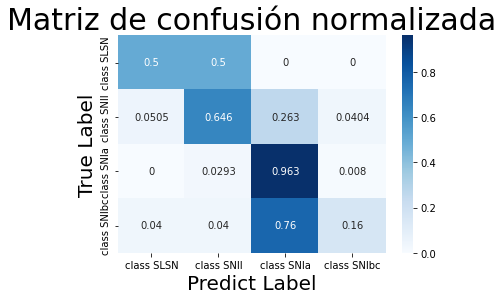

In [65]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

columns = ['class %s' %(i) for i in np.unique(y_sin_codificar)]

confm = confusion_matrix(y_test, pred_labels,normalize='true')
df_cm = pd.DataFrame(confm, index=columns, columns=columns)
ax = sn.heatmap(df_cm, cmap='Blues',fmt='.3g', annot=True)
sn.set(rc={'figure.figsize':(12,8)})
ax.set_title('Matriz de confusión normalizada',fontsize=30)
ax.set_xlabel('Predict Label',fontsize=20)
ax.set_ylabel('True Label',fontsize=20)

In [66]:
import matplotlib.pyplot as plt
importance = best_classifier.feature_importances_

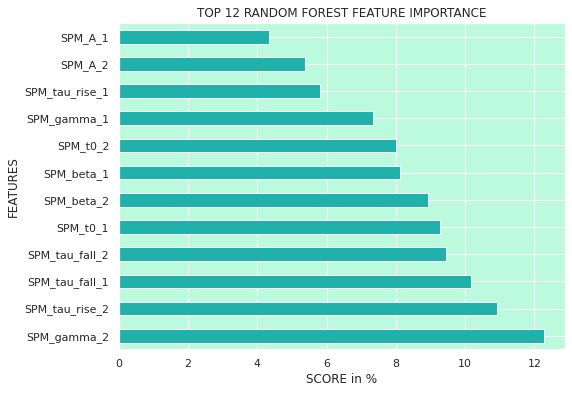

In [69]:
ranking = 12

#plot graph of feature importances for better visualization
fig, ax = plt.subplots(1,figsize=(8, 6))

feat_importances = pd.Series(importance*100, index=features.columns[0:-1])
feat_importances.nlargest(ranking).plot(kind='barh', color='lightseagreen')
title = f"TOP {ranking} RANDOM FOREST FEATURE IMPORTANCE"
plt.title(title)
plt.xlabel("SCORE in %")
plt.ylabel("FEATURES")
ax.set_facecolor('#bbfadc')
plt.show()